In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mutual_info_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
%matplotlib inline

In [3]:
maindir = "D:/Blood/data" # Directory with files
train = pd.read_csv("train_preprocessed.csv")
test = pd.read_csv("test_preprocessed.csv")

In [4]:
# Define target columns
target_columns = ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']

# Separate features and targets
train = train[train.donation_id != 6824].reset_index(drop=True)
X_train = train.drop(columns=target_columns)
X_train.drop(columns=['id'], axis=1, inplace=True)
y_train = train[target_columns]

X_test = test.drop(columns=['id'], axis=1)

In [5]:
encoders = {}
for col in target_columns:
    encoder = LabelEncoder()
    y_train[col] = encoder.fit_transform(y_train[col])
    encoders[col] = encoder

In [6]:
# Calculate MI for each pair of targets
for i in range(len(target_columns)):
    for j in range(i + 1, len(target_columns)):
        mi = mutual_info_score(y_train[target_columns[i]], y_train[target_columns[j]])
        print(f"Mutual Information between {target_columns[i]} and {target_columns[j]}: {mi:.2f}")


Mutual Information between hdl_cholesterol_human and hemoglobin(hgb)_human: 0.01
Mutual Information between hdl_cholesterol_human and cholesterol_ldl_human: 0.02
Mutual Information between hemoglobin(hgb)_human and cholesterol_ldl_human: 0.00


In [7]:
# Load mRMR selected features from JSON
with open("selected_features.json", "r") as file:
    selected_features = json.load(file)

In [8]:
# Apply selected features to train and test data
X_train_target1 = X_train[selected_features["Target1"]]
X_train_target2 = X_train[selected_features["Target2"]]
X_train_target3 = X_train[selected_features["Target3"]]

X_test_target1 = X_test[selected_features["Target1"]]
X_test_target2 = X_test[selected_features["Target2"]]
X_test_target3 = X_test[selected_features["Target3"]]

In [37]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_target2.columns


vif_data["VIF"] = [variance_inflation_factor(X_train_target2.values, i)
                          for i in range(len(X_train_target2.columns))]

vif_data

,feature,VIF
0,humidity,18.532641
1,temperature,225.031980
2,absorbance138,35891.857519
3,absorbance135,30923.260988
4,absorbance44,5167.613945
5,absorbance98,277.984067
6,absorbance139,26273.644640
7,absorbance137,38753.734269
8,absorbance136,37140.128518
9,absorbance117,1476.315770


In [9]:
pca_models = {}
X_train_pca = {}
X_test_pca = {}

for target, X_train_target, X_test_target in zip(
    ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],
    [X_train_target1, X_train_target2, X_train_target3],
    [X_test_target1, X_test_target2, X_test_target3]
):
    print(f"\nApplying PCA for Target: {target}")

    pca = PCA(n_components=int(0.95 * X_train_target.shape[1]))  # Keep 95% of the variance
    X_train_pca[target] = pca.fit_transform(X_train_target)
    X_test_pca[target] = pca.transform(X_test_target)
    pca_models[target] = pca
    print(f"Number of components selected: {pca.n_components_}")

# Evaluate baseline
rfc_results = {}
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for target, X_train_target_pca in X_train_pca.items():
    print(f"\n=== Training Models for Target: {target} ===")
    
    y_target = y_train[target]
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_target_pca, y_target)):
        X_train_fold = X_train_target_pca[train_idx]
        X_val_fold = X_train_target_pca[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        rfc = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                      min_samples_split=15, n_estimators=160,
                                      random_state=42)
        rfc.fit(X_train_fold, y_train_fold)

        y_val_pred = rfc.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        print(f"  Fold {fold + 1}: Accuracy = {accuracy:.4f}")
        fold_accuracies.append(accuracy)

    rfc_results[target] = np.mean(fold_accuracies)
    print(f"\nAverage Accuracy for {target}: {rfc_results[target]:.4f}")

#PCA EVR
for target, pca_model in pca_models.items():
    print(f"\nExplained Variance Ratio for {target}:")
    print(pca_model.explained_variance_ratio_)

print("\n=== Final Results ===")
for target, avg_accuracy in rfc_results.items():
    print(f"Target: {target}, Average Accuracy: {avg_accuracy:.4f}")




Applying PCA for Target: hdl_cholesterol_human
Number of components selected: 9

Applying PCA for Target: hemoglobin(hgb)_human
Number of components selected: 9

Applying PCA for Target: cholesterol_ldl_human
Number of components selected: 9

=== Training Models for Target: hdl_cholesterol_human ===
  Fold 1: Accuracy = 0.9452
  Fold 2: Accuracy = 0.9395
  Fold 3: Accuracy = 0.9514
  Fold 4: Accuracy = 0.9488
  Fold 5: Accuracy = 0.9486

Average Accuracy for hdl_cholesterol_human: 0.9467

=== Training Models for Target: hemoglobin(hgb)_human ===
  Fold 1: Accuracy = 0.9333
  Fold 2: Accuracy = 0.9306
  Fold 3: Accuracy = 0.9311
  Fold 4: Accuracy = 0.9357
  Fold 5: Accuracy = 0.9313

Average Accuracy for hemoglobin(hgb)_human: 0.9324

=== Training Models for Target: cholesterol_ldl_human ===
  Fold 1: Accuracy = 0.9457
  Fold 2: Accuracy = 0.9469
  Fold 3: Accuracy = 0.9426
  Fold 4: Accuracy = 0.9385
  Fold 5: Accuracy = 0.9471

Average Accuracy for cholesterol_ldl_human: 0.9442

Exp

In [36]:
# Function to compute VIF
def calculate_vif(data, target_name):
    """
    Calculate VIF for each feature in the dataset.
    Parameters:
        data: DataFrame of features.
        target_name: Name of the target variabl.
    Returns:
        DataFrame containing VIF for each feature.
    """
    vif_data = pd.DataFrame()
    vif_data["Component"] = [f"PC{i+1}" for i in range(data.shape[1])]
    vif_data["VIF"] = [variance_inflation_factor(data, i) for i in range(data.shape[1])]
    print(f"\nVIF values for target: {target_name}")
    print(vif_data)
    return vif_data

vif_results = {}

for target, X_train_target_pca in X_train_pca.items():
    print(f"\nCalculating VIF for Target: {target}")
    vif_results[target] = calculate_vif(pd.DataFrame(X_train_target_pca), target)



Calculating VIF for Target: hdl_cholesterol_human

VIF values for target: hdl_cholesterol_human
  Component  VIF
0       PC1  1.0
1       PC2  1.0
2       PC3  1.0
3       PC4  1.0
4       PC5  1.0
5       PC6  1.0
6       PC7  1.0
7       PC8  1.0
8       PC9  1.0

Calculating VIF for Target: hemoglobin(hgb)_human

VIF values for target: hemoglobin(hgb)_human
  Component  VIF
0       PC1  1.0
1       PC2  1.0
2       PC3  1.0
3       PC4  1.0
4       PC5  1.0
5       PC6  1.0
6       PC7  1.0
7       PC8  1.0
8       PC9  1.0

Calculating VIF for Target: cholesterol_ldl_human

VIF values for target: cholesterol_ldl_human
  Component  VIF
0       PC1  1.0
1       PC2  1.0
2       PC3  1.0
3       PC4  1.0
4       PC5  1.0
5       PC6  1.0
6       PC7  1.0
7       PC8  1.0
8       PC9  1.0



Visualizing Train-Test Distribution Shift for Target: hdl_cholesterol_human


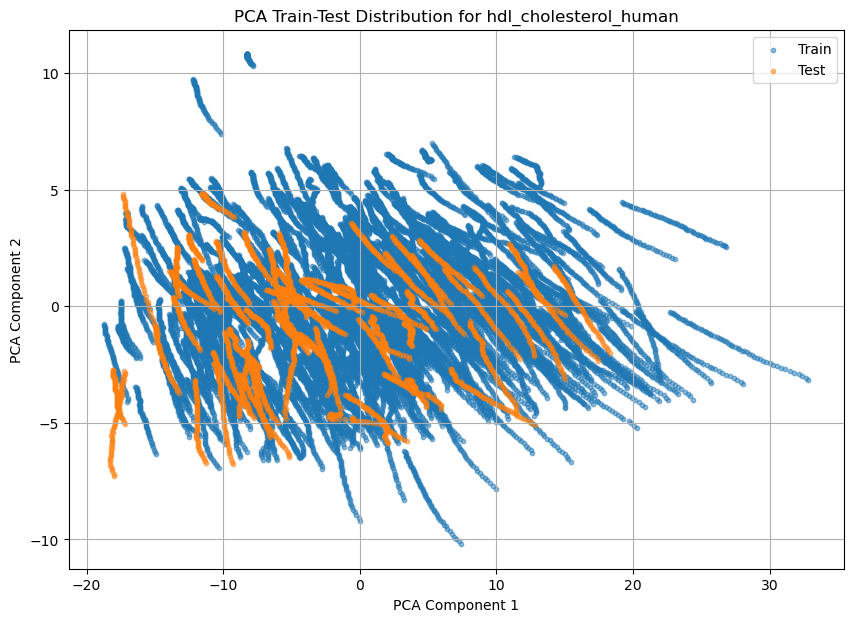

Kolmogorov-Smirnov Statistic for PCA Component 1: 0.1995988958368543, P-value: 5.4190168698150975e-114
Kolmogorov-Smirnov Statistic for PCA Component 2: 0.12200552081572869, P-value: 1.2453673046418502e-42

Visualizing Train-Test Distribution Shift for Target: hemoglobin(hgb)_human


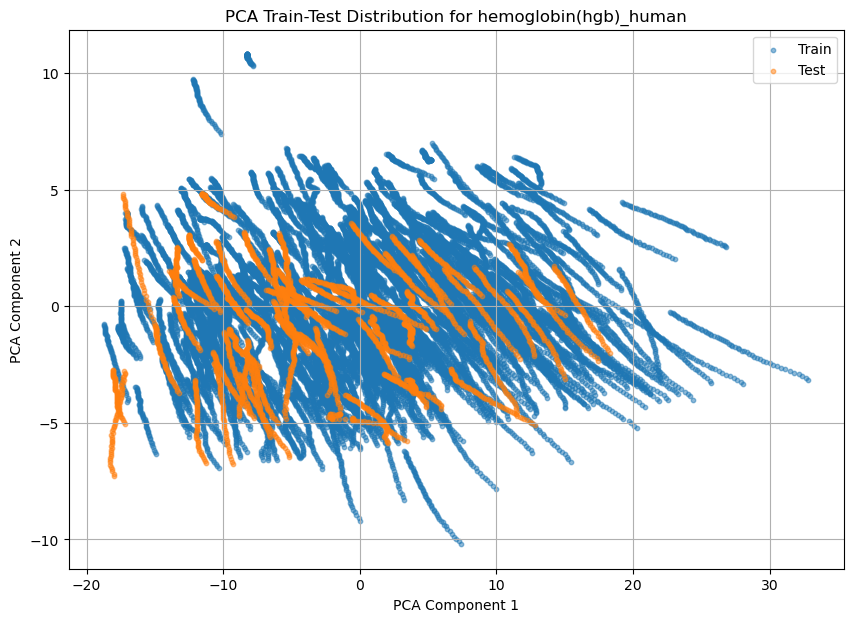

Kolmogorov-Smirnov Statistic for PCA Component 1: 0.1995988958368543, P-value: 5.4190168698150975e-114
Kolmogorov-Smirnov Statistic for PCA Component 2: 0.12200552081572869, P-value: 1.2453673046418502e-42

Visualizing Train-Test Distribution Shift for Target: cholesterol_ldl_human


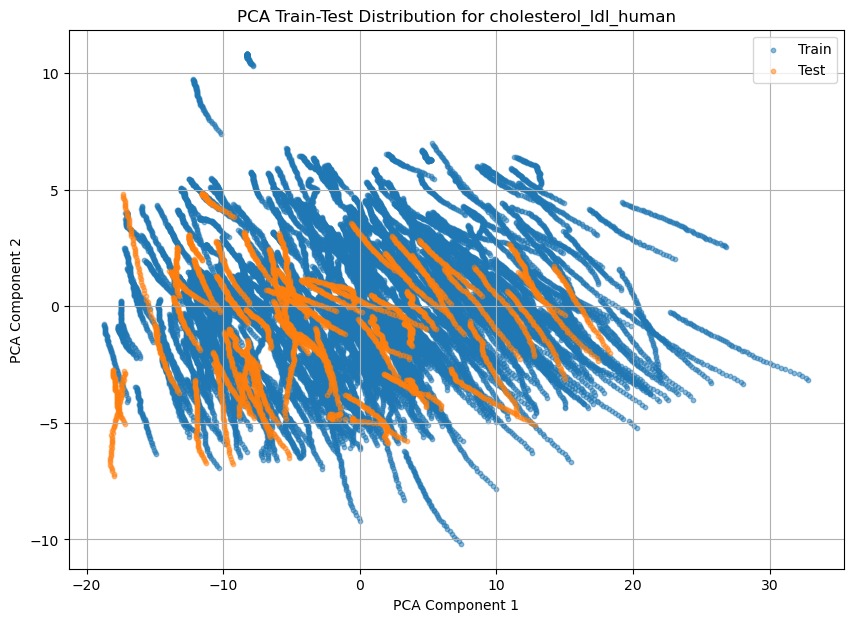

Kolmogorov-Smirnov Statistic for PCA Component 1: 0.1995988958368543, P-value: 5.4190168698150975e-114
Kolmogorov-Smirnov Statistic for PCA Component 2: 0.12200552081572869, P-value: 1.2453673046418502e-42


In [38]:
from scipy.stats import ks_2samp

for target in ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']:
    print(f"\nVisualizing Train-Test Distribution Shift for Target: {target}")
    
    X_train_target_pca = X_train_pca[target]
    X_test_target_raw = X_test_pca[target]  # Use raw test set as-is
    
    plt.figure(figsize=(10, 7))
    plt.scatter(X_train_target_pca[:, 0], X_train_target_pca[:, 1], alpha=0.5, label="Train", s=10)
    plt.scatter(X_test_target_raw[:, 0], X_test_target_raw[:, 1], alpha=0.5, label="Test", s=10)
    plt.title(f"PCA Train-Test Distribution for {target}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    ks_stat_1, p_value_1 = ks_2samp(X_train_target_pca[:, 0], X_test_target_raw[:, 0])
    ks_stat_2, p_value_2 = ks_2samp(X_train_target_pca[:, 1], X_test_target_raw[:, 1])
    print(f"Kolmogorov-Smirnov Statistic for PCA Component 1: {ks_stat_1}, P-value: {p_value_1}")
    print(f"Kolmogorov-Smirnov Statistic for PCA Component 2: {ks_stat_2}, P-value: {p_value_2}")

In [11]:
# Define Neural Network Model
def create_nn(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

ensemble_test_predictions = {}

for target, X_train_target_pca, X_test_target, pca_model in zip(
    ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],
    [X_train_pca['hdl_cholesterol_human'], X_train_pca['hemoglobin(hgb)_human'], X_train_pca['cholesterol_ldl_human']],
    [X_test_target1, X_test_target2, X_test_target3],
    [pca_models['hdl_cholesterol_human'], pca_models['hemoglobin(hgb)_human'], pca_models['cholesterol_ldl_human']]
):
    y_target = y_train[target]
    print(f"\n=== Training Models for Target: {target} ===")
    
    # Apply PCA to test set
    X_test_target_pca = pca_model.transform(X_test_target)
    
    rfc_fold_preds = []
    nn_fold_preds = []
    test_rfc_preds = []
    test_nn_preds = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_target_pca, y_target)):
        print(f"Fold {fold + 1}")
        
        # Train/Validation Split
        X_train_fold = X_train_target_pca[train_idx]
        X_val_fold = X_train_target_pca[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]
        
        # Train Random Forest Classifier
        rfc = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                      min_samples_split=15, n_estimators=160,
                                      random_state=42)
        rfc.fit(X_train_fold, y_train_fold)
        rfc_val_pred = rfc.predict_proba(X_val_fold)
        rfc_test_pred = rfc.predict_proba(X_test_target_pca)
        rfc_fold_preds.append(rfc_val_pred)
        test_rfc_preds.append(rfc_test_pred)
        
        # Train Neural Network
        nn = create_nn(input_dim=X_train_fold.shape[1], output_dim=len(np.unique(y_target)))
        nn.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
        nn_val_pred = nn.predict(X_val_fold)
        nn_test_pred = nn.predict(X_test_target_pca)
        nn_fold_preds.append(nn_val_pred)
        test_nn_preds.append(nn_test_pred)
        
        # Combine Predictions (Averaging Ensemble)
        combined_val_pred = (rfc_val_pred + nn_val_pred) / 2
        combined_val_class = np.argmax(combined_val_pred, axis=1)
        
        # Evaluate Combined Model
        accuracy = accuracy_score(y_val_fold, combined_val_class)
        print(f"  Combined Model Accuracy: {accuracy:.4f}")
    
    # Combine Test Set Predictions
    avg_rfc_test_pred = np.mean(test_rfc_preds, axis=0)
    avg_nn_test_pred = np.mean(test_nn_preds, axis=0)
    combined_test_pred = (avg_rfc_test_pred + avg_nn_test_pred) / 2
    ensemble_test_predictions[target] = np.argmax(combined_test_pred, axis=1)

for target, preds in ensemble_test_predictions.items():
    print(f"\nPredictions for {target}:")
    print(preds)


=== Training Models for Target: hdl_cholesterol_human ===
Fold 1
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Combined Model Accuracy: 0.9007
Fold 2
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.8904
Fold 3
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Combined Model Accuracy: 0.9148
Fold 4
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.8926
Fold 5
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9005

=== Training Models for Target: hemoglobin(hgb)_human ===
Fold 1
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9335
Fold 2
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9330
Fold 3
182/182 ━━━━━━

In [10]:
# Define weights for ensemble
weights = {"rfc": 0.6, "nn": 0.4}  

def create_nn(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

ensemble_test_predictions = {}

for target, X_train_target_pca, X_test_target, pca_model in zip(
    ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],
    [X_train_pca['hdl_cholesterol_human'], X_train_pca['hemoglobin(hgb)_human'], X_train_pca['cholesterol_ldl_human']],
    [X_test_target1, X_test_target2, X_test_target3],
    [pca_models['hdl_cholesterol_human'], pca_models['hemoglobin(hgb)_human'], pca_models['cholesterol_ldl_human']]
):
    y_target = y_train[target]
    print(f"\n=== Training Models for Target: {target} ===")
    
    X_test_target_pca = pca_model.transform(X_test_target)
    
    rfc_fold_preds = []
    nn_fold_preds = []
    test_rfc_preds = []
    test_nn_preds = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_target_pca, y_target)):
        print(f"Fold {fold + 1}")
        
        # Train/Validation Split
        X_train_fold = X_train_target_pca[train_idx]
        X_val_fold = X_train_target_pca[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        # Train Random Forest Classifier
        rfc = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                      min_samples_split=15, n_estimators=160,
                                      random_state=42)
        rfc.fit(X_train_fold, y_train_fold)
        rfc_val_pred = rfc.predict_proba(X_val_fold)
        rfc_test_pred = rfc.predict_proba(X_test_target_pca)
        rfc_fold_preds.append(rfc_val_pred)
        test_rfc_preds.append(rfc_test_pred)

        # Train Neural Network
        nn = create_nn(input_dim=X_train_fold.shape[1], output_dim=len(np.unique(y_target)))
        nn.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
        nn_val_pred = nn.predict(X_val_fold)
        nn_test_pred = nn.predict(X_test_target_pca)
        nn_fold_preds.append(nn_val_pred)
        test_nn_preds.append(nn_test_pred)

        # Combine Predictions (Weighted Averaging)
        combined_val_pred = (weights["rfc"] * rfc_val_pred + 
                             weights["nn"] * nn_val_pred)
        combined_val_class = np.argmax(combined_val_pred, axis=1)

        accuracy = accuracy_score(y_val_fold, combined_val_class)
        print(f"  Combined Model Accuracy: {accuracy:.4f}")

    # Combine Test Set Predictions
    avg_rfc_test_pred = np.mean(test_rfc_preds, axis=0)
    avg_nn_test_pred = np.mean(test_nn_preds, axis=0)
    combined_test_pred = (weights["rfc"] * avg_rfc_test_pred + 
                          weights["nn"] * avg_nn_test_pred)
    ensemble_test_predictions[target] = np.argmax(combined_test_pred, axis=1)

for target, preds in ensemble_test_predictions.items():
    print(f"\nPredictions for {target}:")
    print(preds)


=== Training Models for Target: hdl_cholesterol_human ===
Fold 1
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.8926
Fold 2
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.8873
Fold 3
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Combined Model Accuracy: 0.9045
Fold 4
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.8950
Fold 5
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9003

=== Training Models for Target: hemoglobin(hgb)_human ===
Fold 1
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9072
Fold 2
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9045
Fold 3
182/182 ━━━━━━

In [11]:
decoding_map = {'hdl_cholesterol_human': {2:'ok', 1:'low', 0:'high'},
'hemoglobin(hgb)_human': {2:'ok', 1:'low', 0:'high'},
'cholesterol_ldl_human': {2:'ok', 1:'low', 0:'high'}} 
decoded_predictions = {}
for target_name, encoded_preds in ensemble_test_predictions.items():
    decoded_predictions[target_name] = [decoding_map[target_name][pred] for pred in encoded_preds]

In [12]:
submission_data = []
test_ids = test['donation_id']
for i, test_id in enumerate(test_ids):
    submission_data.append({"Reading_ID": f"{test_id}_hdl_cholesterol_human", "target": decoded_predictions["hdl_cholesterol_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_hemoglobin(hgb)_human", "target": decoded_predictions["hemoglobin(hgb)_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_cholesterol_ldl_human", "target": decoded_predictions["cholesterol_ldl_human"][i]})

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv("submission_ensemble_optim.csv", index=False)

In [17]:
from scipy.fft import fft
def compute_fft_features(data, num_components=10):
    """
    Computes FFT features for the given data.

    Parameters:
    - data: Numpy array of shape (n_samples, n_features).
    - num_components: Number of dominant frequencies to keep.

    Returns:
    - fft_features: Numpy array of shape (n_samples, num_components).
    """
    fft_transformed = fft(data, axis=1)
    fft_magnitudes = np.abs(fft_transformed)[:, :num_components]
    return fft_magnitudes
    
fft_features_raw_train = {}
fft_features_raw_test = {}

for target, X_train_raw, X_test_raw in zip(
    ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],
    [X_train_target1, X_train_target2, X_train_target3],
    [X_test_target1, X_test_target2, X_test_target3]
):
    print(f"Computing FFT features from raw data for Target: {target}")
    fft_features_raw_train[target] = compute_fft_features(X_train_raw)
    fft_features_raw_test[target] = compute_fft_features(X_test_raw)

# Combine FFT from Raw Data with Precomputed PCA Features
X_train_combined = {}
X_test_combined = {}

for target in ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']:
    print(f"Combining PCA and FFT features for Target: {target}")
    X_train_combined[target] = np.hstack((X_train_pca[target], fft_features_raw_train[target]))
    X_test_combined[target] = np.hstack((X_test_pca[target], fft_features_raw_test[target]))

print("Combined PCA and FFT features ready!")

Computing FFT features from raw data for Target: hdl_cholesterol_human
Computing FFT features from raw data for Target: hemoglobin(hgb)_human
Computing FFT features from raw data for Target: cholesterol_ldl_human
Combining PCA and FFT features for Target: hdl_cholesterol_human
Combining PCA and FFT features for Target: hemoglobin(hgb)_human
Combining PCA and FFT features for Target: cholesterol_ldl_human
Combined PCA and FFT features ready!


In [22]:
from scipy.fft import fft

# Define weights for ensemble
weights = {"rfc": 0.6, "nn": 0.4}

def create_nn(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def compute_fft_features(data, num_components=10):
    fft_transformed = fft(data, axis=1)
    fft_magnitudes = np.abs(fft_transformed)[:, :num_components]
    return fft_magnitudes

fft_features_train = {}
fft_features_test = {}

for target, X_train_raw, X_test_raw in zip(
    ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],
    [X_train_target1, X_train_target2, X_train_target3],
    [X_test_target1, X_test_target2, X_test_target3]
):
    print(f"Computing FFT features for Target: {target}")
    fft_features_train[target] = compute_fft_features(X_train_raw)
    fft_features_test[target] = compute_fft_features(X_test_raw)

# Standardize FFT Features
scaler_fft = StandardScaler()
fft_features_train_scaled = {k: scaler_fft.fit_transform(v) for k, v in fft_features_train.items()}
fft_features_test_scaled = {k: scaler_fft.transform(v) for k, v in fft_features_test.items()}

# Combine FFT with PCA-transformed data
X_train_combined = {}
X_test_combined = {}

for target in ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']:
    print(f"Combining PCA and FFT features for Target: {target}")
    X_train_combined[target] = np.hstack((X_train_pca[target], fft_features_train_scaled[target]))
    X_test_combined[target] = np.hstack((X_test_pca[target], fft_features_test_scaled[target]))

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
ensemble_test_predictions = {}

for target, X_train_target, X_test_target in zip(
    ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],
    [X_train_combined['hdl_cholesterol_human'], 
     X_train_combined['hemoglobin(hgb)_human'], 
     X_train_combined['cholesterol_ldl_human']],
    [X_test_combined['hdl_cholesterol_human'], 
     X_test_combined['hemoglobin(hgb)_human'], 
     X_test_combined['cholesterol_ldl_human']]
):
    y_target = y_train[target]
    print(f"\n=== Training Models for Target: {target} ===")
    
    rfc_fold_preds = []
    nn_fold_preds = []
    test_rfc_preds = []
    test_nn_preds = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_target, y_target)):
        print(f"Fold {fold + 1}")
        
        X_train_fold = X_train_target[train_idx]
        X_val_fold = X_train_target[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        # Train Random Forest Classifier
        rfc = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                      min_samples_split=15, n_estimators=160,
                                      random_state=42)
        rfc.fit(X_train_fold, y_train_fold)
        rfc_val_pred = rfc.predict_proba(X_val_fold)
        rfc_test_pred = rfc.predict_proba(X_test_target)
        rfc_fold_preds.append(rfc_val_pred)
        test_rfc_preds.append(rfc_test_pred)

        # Train Neural Network
        nn = create_nn(input_dim=X_train_fold.shape[1], output_dim=len(np.unique(y_target)))
        nn.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
        nn_val_pred = nn.predict(X_val_fold)
        nn_test_pred = nn.predict(X_test_target)
        nn_fold_preds.append(nn_val_pred)
        test_nn_preds.append(nn_test_pred)

        # Combine Predictions (Weighted Averaging)
        combined_val_pred = (weights["rfc"] * rfc_val_pred + 
                             weights["nn"] * nn_val_pred)
        combined_val_class = np.argmax(combined_val_pred, axis=1)

        # Evaluate Combined Model
        accuracy = accuracy_score(y_val_fold, combined_val_class)
        print(f"  Combined Model Accuracy: {accuracy:.4f}")

    # Combine Test Set Predictions
    avg_rfc_test_pred = np.mean(test_rfc_preds, axis=0)
    avg_nn_test_pred = np.mean(test_nn_preds, axis=0)
    combined_test_pred = (weights["rfc"] * avg_rfc_test_pred + 
                          weights["nn"] * avg_nn_test_pred)
    ensemble_test_predictions[target] = np.argmax(combined_test_pred, axis=1)

for target, preds in ensemble_test_predictions.items():
    print(f"\nPredictions for {target}:")
    print(preds)


Computing FFT features for Target: hdl_cholesterol_human
Computing FFT features for Target: hemoglobin(hgb)_human
Computing FFT features for Target: cholesterol_ldl_human
Combining PCA and FFT features for Target: hdl_cholesterol_human
Combining PCA and FFT features for Target: hemoglobin(hgb)_human
Combining PCA and FFT features for Target: cholesterol_ldl_human

=== Training Models for Target: hdl_cholesterol_human ===
Fold 1
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9277
Fold 2
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9282
Fold 3
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9387
Fold 4
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9229
Fold 5
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

In [23]:
decoding_map = {'hdl_cholesterol_human': {2:'ok', 1:'low', 0:'high'},
'hemoglobin(hgb)_human': {2:'ok', 1:'low', 0:'high'},
'cholesterol_ldl_human': {2:'ok', 1:'low', 0:'high'}} 
decoded_predictions = {}
for target_name, encoded_preds in ensemble_test_predictions.items():
    decoded_predictions[target_name] = [decoding_map[target_name][pred] for pred in encoded_preds]

In [24]:
submission_data = []
test_ids = test['donation_id']
for i, test_id in enumerate(test_ids):
    submission_data.append({"Reading_ID": f"{test_id}_hdl_cholesterol_human", "target": decoded_predictions["hdl_cholesterol_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_hemoglobin(hgb)_human", "target": decoded_predictions["hemoglobin(hgb)_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_cholesterol_ldl_human", "target": decoded_predictions["cholesterol_ldl_human"][i]})

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv("submission_ensemble_optim_fft.csv", index=False)

In [28]:
from sklearn.linear_model import LogisticRegression

def create_nn(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Meta-model
meta_model = LogisticRegression()

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

meta_train = {}
meta_test = {}
ensemble_test_predictions = {}

for target in ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']:
    meta_train[target] = []
    meta_test[target] = []

for target, X_train_combined, X_test_combined in zip(
    ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],
    [X_train_combined['hdl_cholesterol_human'], X_train_combined['hemoglobin(hgb)_human'], X_train_combined['cholesterol_ldl_human']],
    [X_test_combined['hdl_cholesterol_human'], X_test_combined['hemoglobin(hgb)_human'], X_test_combined['cholesterol_ldl_human']]
):
    y_target = y_train[target]
    print(f"\n=== Training Models for Target: {target} ===")
    
    base_test_predictions = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_combined, y_target)):
        print(f"Fold {fold + 1}")
        
        X_train_fold = X_train_combined[train_idx]
        X_val_fold = X_train_combined[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]
        
        # Random Forest Classifier
        rfc = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                      min_samples_split=15, n_estimators=160,
                                      random_state=42)
        rfc.fit(X_train_fold, y_train_fold)
        rfc_val_pred = rfc.predict_proba(X_val_fold)
        rfc_test_pred = rfc.predict_proba(X_test_combined)
        
        # Neural Network
        nn = create_nn(input_dim=X_train_fold.shape[1], output_dim=len(np.unique(y_target)))
        nn.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
        nn_val_pred = nn.predict(X_val_fold)
        nn_test_pred = nn.predict(X_test_combined)
        
        meta_train[target].append(np.hstack((rfc_val_pred, nn_val_pred)))
        base_test_predictions.append(np.hstack((rfc_test_pred, nn_test_pred)))

    meta_test[target] = np.mean(base_test_predictions, axis=0)

meta_train_combined = {}
meta_test_combined = {}
final_predictions = {}

for target in meta_train.keys():
    print(f"\nTraining Meta-Model for Target: {target}")

    X_meta_train = np.vstack(meta_train[target]) 
    y_meta_train = y_train[target].values 

    meta_model.fit(X_meta_train, y_meta_train)
    
    X_meta_test = meta_test[target]
    final_predictions[target] = meta_model.predict(X_meta_test)

for target, preds in final_predictions.items():
    print(f"\nPredictions for {target}:")
    print(preds)



=== Training Models for Target: hdl_cholesterol_human ===
Fold 1
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
Fold 2
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 3
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 4
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 5
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

=== Training Models for Target: hemoglobin(hgb)_human ===
Fold 1
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 2
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 4
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 5
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━

ValueError: Found input variables with inconsistent numbers of samples: [29100, 145500]

In [35]:
decoding_map = {'hdl_cholesterol_human': {2:'ok', 1:'low', 0:'high'},
'hemoglobin(hgb)_human': {2:'ok', 1:'low', 0:'high'},
'cholesterol_ldl_human': {2:'ok', 1:'low', 0:'high'}} 
decoded_predictions = {}
for target_name, encoded_preds in final_predictions.items():
    decoded_predictions[target_name] = [decoding_map[target_name][pred] for pred in encoded_preds]

In [36]:
submission_data = []
test_ids = test['donation_id']
for i, test_id in enumerate(test_ids):
    submission_data.append({"Reading_ID": f"{test_id}_hdl_cholesterol_human", "target": decoded_predictions["hdl_cholesterol_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_hemoglobin(hgb)_human", "target": decoded_predictions["hemoglobin(hgb)_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_cholesterol_ldl_human", "target": decoded_predictions["cholesterol_ldl_human"][i]})

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv("submission_meta_optim.csv", index=False)

In [ ]:
Feature generation

In [40]:
from sklearn.preprocessing import PolynomialFeatures

#Polynomial Features for FFT + PCA Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
engineered_features_train = {}
engineered_features_test = {}

for target in ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']:
    print(f"\nGenerating Polynomial Features for Target: {target}")
    
    combined_train = np.hstack((X_train_pca[target], fft_features_raw_train[target]))
    combined_test = np.hstack((X_test_pca[target], fft_features_raw_test[target]))
    
    poly_train = poly.fit_transform(combined_train)
    poly_test = poly.transform(combined_test)
    
    engineered_features_train[target] = poly_train
    engineered_features_test[target] = poly_test


Generating Polynomial Features for Target: hdl_cholesterol_human

Generating Polynomial Features for Target: hemoglobin(hgb)_human

Generating Polynomial Features for Target: cholesterol_ldl_human


In [41]:
weights = {"rfc": 0.6, "nn": 0.4}

def create_nn(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

final_train_features = {}
final_test_features = {}

for target in ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']:
    print(f"\nCombining All Features for Target: {target}")
    final_train_features[target] = np.hstack((
        X_train_pca[target],
        fft_features_raw_train[target],
        engineered_features_train[target]
    ))
    final_test_features[target] = np.hstack((
        X_test_pca[target],
        fft_features_raw_test[target],
        engineered_features_test[target]
    ))

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

ensemble_test_predictions = {}

for target in ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']:
    print(f"\n=== Training Ensemble Models for Target: {target} ===")
    y_target = y_train[target]
    
    rfc_fold_preds = []
    nn_fold_preds = []
    test_rfc_preds = []
    test_nn_preds = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(final_train_features[target], y_target)):
        print(f"Fold {fold + 1}")
        
        X_train_fold = final_train_features[target][train_idx]
        X_val_fold = final_train_features[target][val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        rfc = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                      min_samples_split=15, n_estimators=160,
                                      random_state=42)
        rfc.fit(X_train_fold, y_train_fold)
        rfc_val_pred = rfc.predict_proba(X_val_fold)
        rfc_test_pred = rfc.predict_proba(final_test_features[target])
        rfc_fold_preds.append(rfc_val_pred)
        test_rfc_preds.append(rfc_test_pred)

        nn = create_nn(input_dim=X_train_fold.shape[1], output_dim=len(np.unique(y_target)))
        nn.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
        nn_val_pred = nn.predict(X_val_fold)
        nn_test_pred = nn.predict(final_test_features[target])
        nn_fold_preds.append(nn_val_pred)
        test_nn_preds.append(nn_test_pred)

        combined_val_pred = (weights["rfc"] * rfc_val_pred + 
                             weights["nn"] * nn_val_pred)
        combined_val_class = np.argmax(combined_val_pred, axis=1)

        accuracy = accuracy_score(y_val_fold, combined_val_class)
        print(f"  Combined Model Accuracy: {accuracy:.4f}")

    avg_rfc_test_pred = np.mean(test_rfc_preds, axis=0)
    avg_nn_test_pred = np.mean(test_nn_preds, axis=0)
    combined_test_pred = (weights["rfc"] * avg_rfc_test_pred + 
                          weights["nn"] * avg_nn_test_pred)
    ensemble_test_predictions[target] = np.argmax(combined_test_pred, axis=1)

for target, preds in ensemble_test_predictions.items():
    print(f"\nPredictions for {target}:")
    print(preds)


Combining All Features for Target: hdl_cholesterol_human

Combining All Features for Target: hemoglobin(hgb)_human

Combining All Features for Target: cholesterol_ldl_human

=== Training Ensemble Models for Target: hdl_cholesterol_human ===
Fold 1
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
  Combined Model Accuracy: 0.9368
Fold 2
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9557
Fold 3
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9576
Fold 4
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Combined Model Accuracy: 0.9493
Fold 5
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Combined Model Accuracy: 0.9517

=== Training Ensemble Models for Target: hemoglobin(hgb)_human ===
Fold 1
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━

In [43]:
decoding_map = {'hdl_cholesterol_human': {2:'ok', 1:'low', 0:'high'},
'hemoglobin(hgb)_human': {2:'ok', 1:'low', 0:'high'},
'cholesterol_ldl_human': {2:'ok', 1:'low', 0:'high'}} 
decoded_predictions = {}
for target_name, encoded_preds in ensemble_test_predictions.items():
    decoded_predictions[target_name] = [decoding_map[target_name][pred] for pred in encoded_preds]

In [44]:
submission_data = []
test_ids = test['donation_id']
for i, test_id in enumerate(test_ids):
    submission_data.append({"Reading_ID": f"{test_id}_hdl_cholesterol_human", "target": decoded_predictions["hdl_cholesterol_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_hemoglobin(hgb)_human", "target": decoded_predictions["hemoglobin(hgb)_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_cholesterol_ldl_human", "target": decoded_predictions["cholesterol_ldl_human"][i]})

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv("submission_ensemble_featurepoly.csv", index=False)

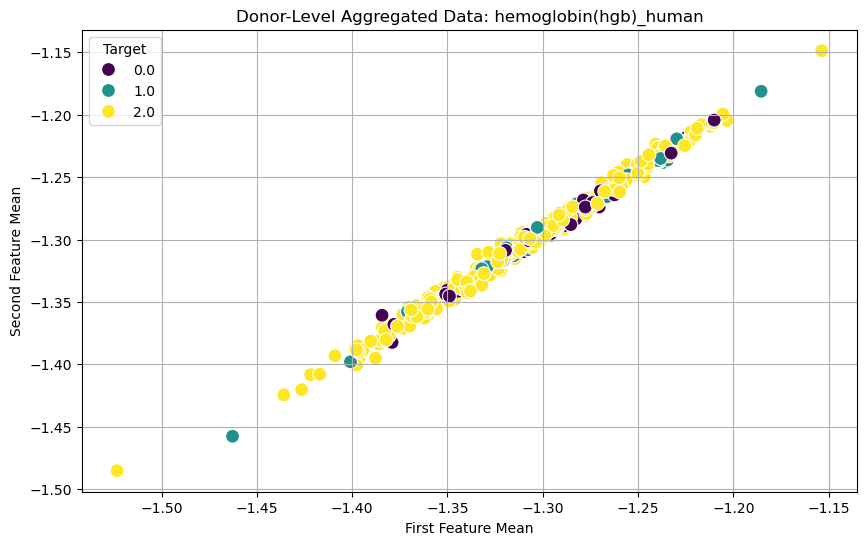

In [35]:
def analyze_donor_level(data, labels, donation_id_column, target_name, std_column=None):
    """
    Analyze donor-level data consistency and variation.

    Parameters:
    - data: Preprocessed spectral data.
    - labels: Corresponding labels for the data.
    - donation_id_column: Column indicating unique donor IDs.
    - target_name: Target variable for analysis.
    - std_column: Column for existing standard deviation in the train set.

    Returns:
    - donor_aggregated: Aggregated donor-level statistics.
    """
    if donation_id_column not in data.columns:
        raise KeyError(f"Column '{donation_id_column}' not found in the dataset.")

    numeric_columns = data.select_dtypes(include="number").columns.tolist()
    if donation_id_column in numeric_columns:
        numeric_columns.remove(donation_id_column)
    if std_column in numeric_columns:
        numeric_columns.remove(std_column)

    donor_means = data.groupby(donation_id_column)[numeric_columns].mean()
    donor_stds = (
        data.groupby(donation_id_column)[numeric_columns].std()
        if std_column is None
        else data.groupby(donation_id_column)[std_column].mean()
    )

    donor_aggregated = pd.concat([donor_means, donor_stds.add_suffix('_std')], axis=1)

    labels_aligned = labels.groupby(data[donation_id_column]).mean()
    donor_aggregated[target_name] = labels_aligned[target_name]

    # Visualize donor-level aggregated statistics
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=donor_aggregated,
        x=donor_aggregated.iloc[:, 0], 
        y=donor_aggregated.iloc[:, 1],  
        hue=donor_aggregated[target_name],
        palette="viridis",
        s=100
    )
    plt.title(f"Donor-Level Aggregated Data: {target_name}")
    plt.xlabel("First Feature Mean")
    plt.ylabel("Second Feature Mean")
    plt.legend(title="Target")
    plt.grid()
    plt.show()
    
    return donor_aggregated
donor_summary_train = analyze_donor_level(
    X_train, y_train, 
    donation_id_column="donation_id",  
    target_name="hemoglobin(hgb)_human",
    std_column="std"  
)


In [11]:
from sklearn.model_selection import StratifiedKFold

# Map targets to their respective datasets
target_to_dataset = {
    "hdl_cholesterol_human": X_train_target1,
    "hemoglobin(hgb)_human": X_train_target2,
    "cholesterol_ldl_human": X_train_target3,
}

# Redo Stratified K-Fold for each target
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store splits for each target
splits = {}

# Process each target
for target, X_target in target_to_dataset.items():
    
    # Get the corresponding labels
    y_target = y_train[target]
    
    # Compute Stratified K-Fold splits
    splits[target] = list(skf.split(X_target, y_target))

In [331]:
baseline_model = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                       min_samples_split=15, n_estimators=160,
                                       random_state=42)

results = {}

for target, fold_splits in splits.items():
    print(f"\n=== Training Models for Target: {target} ===")

    # Access target-specific dataset and labels
    X_target = target_to_dataset[target]
    y_target = y_train[target]

    results[target] = []

    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(fold_splits):
        # Split the data
        X_train_fold = X_target.iloc[train_idx]
        X_val_fold = X_target.iloc[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        # Train the model
        model = baseline_model
        model.fit(X_train_fold, y_train_fold)

        # Validate the model
        y_val_pred = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        print(f"  Fold {fold + 1}: Accuracy = {accuracy:.4f}")

        # Store fold results
        results[target].append(accuracy)

# Summary of results
for target, accuracies in results.items():
    print(f"\n{target} Average Accuracy: {sum(accuracies) / len(accuracies):.4f}")



=== Training Models for Target: hdl_cholesterol_human ===
  Fold 1: Accuracy = 0.9299
  Fold 2: Accuracy = 0.9268
  Fold 3: Accuracy = 0.9404
  Fold 4: Accuracy = 0.9302
  Fold 5: Accuracy = 0.9318

=== Training Models for Target: hemoglobin(hgb)_human ===
  Fold 1: Accuracy = 0.9229
  Fold 2: Accuracy = 0.9249
  Fold 3: Accuracy = 0.9235
  Fold 4: Accuracy = 0.9271
  Fold 5: Accuracy = 0.9266

=== Training Models for Target: cholesterol_ldl_human ===
  Fold 1: Accuracy = 0.9332
  Fold 2: Accuracy = 0.9363
  Fold 3: Accuracy = 0.9299
  Fold 4: Accuracy = 0.9296
  Fold 5: Accuracy = 0.9344

hdl_cholesterol_human Average Accuracy: 0.9318

hemoglobin(hgb)_human Average Accuracy: 0.9250

cholesterol_ldl_human Average Accuracy: 0.9326


In [332]:
baseline_model_params = {
   'max_depth': 30, 
    'min_samples_leaf': 1,
    'min_samples_split': 16, 
    'n_estimators': 230
}

target_to_dataset = {
    "hdl_cholesterol_human": (X_train_target1, X_test_target1),
    "hemoglobin(hgb)_human": (X_train_target2, X_test_target2),
    "cholesterol_ldl_human": (X_train_target3, X_test_target3),
}

test_predictions = {}

for target, (X_train_target, X_test_target) in target_to_dataset.items():
    print(f"Training model for {target} and predicting on the test set...")

    # Target-specific labels
    y_train_target = y_train[target]

    model = RandomForestClassifier(**baseline_model_params)
    model.fit(X_train_target, y_train_target)

    y_test_pred = model.predict(X_test_target)
    test_predictions[target] = y_test_pred

Training model for hdl_cholesterol_human and predicting on the test set...
Training model for hemoglobin(hgb)_human and predicting on the test set...
Training model for cholesterol_ldl_human and predicting on the test set...


In [333]:
decoding_map = {'hdl_cholesterol_human': {2:'ok', 1:'low', 0:'high'},
'hemoglobin(hgb)_human': {2:'ok', 1:'low', 0:'high'},
'cholesterol_ldl_human': {2:'ok', 1:'low', 0:'high'}} 
decoded_predictions = {}
for target_name, encoded_preds in test_predictions.items():
    decoded_predictions[target_name] = [decoding_map[target_name][pred] for pred in encoded_preds]

In [334]:
submission_data = []
test_ids = test['donation_id']
for i, test_id in enumerate(test_ids):
    submission_data.append({"Reading_ID": f"{test_id}_hdl_cholesterol_human", "target": decoded_predictions["hdl_cholesterol_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_hemoglobin(hgb)_human", "target": decoded_predictions["hemoglobin(hgb)_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_cholesterol_ldl_human", "target": decoded_predictions["cholesterol_ldl_human"][i]})

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv("submission_baseline_optim_new.csv", index=False)

In [63]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

# Objective function
def objective(params):
    # Unpack hyperparameters
    n_estimators = int(params["n_estimators"])
    max_depth = int(params["max_depth"])
    min_samples_split = int(params["min_samples_split"])
    min_samples_leaf = int(params["min_samples_leaf"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    accuracy = cross_val_score(model, X_train, y_train.iloc[:,0], cv=5, scoring="accuracy").mean()

    # Return negative accuracy (because Hyperopt minimizes)
    return {"loss": -accuracy, "status": STATUS_OK}

In [64]:
# Define the hyperparameter space
search_space = {
    "n_estimators": hp.quniform("n_estimators", 50, 300, 10),  
    "max_depth": hp.quniform("max_depth", 5, 50, 5),          
    "min_samples_split": hp.quniform("min_samples_split", 2, 20, 1),  
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 10, 1)      
}

In [65]:
trials = Trials()

best_params = fmin(
    fn=objective,                
    space=search_space,          
    algo=tpe.suggest,            # Tree of Parzen Estimators (TPE) algorithm
    max_evals=10,                
    trials=trials,              
    rstate=np.random.default_rng(42)  
)

print("Best Hyperparameters:", best_params)

100%|██████████████████████████████████████████████| 10/10 [22:56<00:00, 137.60s/trial, best loss: -0.5928462709284628]
Best Hyperparameters: {'max_depth': 30.0, 'min_samples_leaf': 1.0, 'min_samples_split': 16.0, 'n_estimators': 230.0}


In [66]:
# Convert best_params to integers (if necessary)
best_params = {
    "n_estimators": int(best_params["n_estimators"]),
    "max_depth": int(best_params["max_depth"]),
    "min_samples_split": int(best_params["min_samples_split"]),
    "min_samples_leaf": int(best_params["min_samples_leaf"]),
}

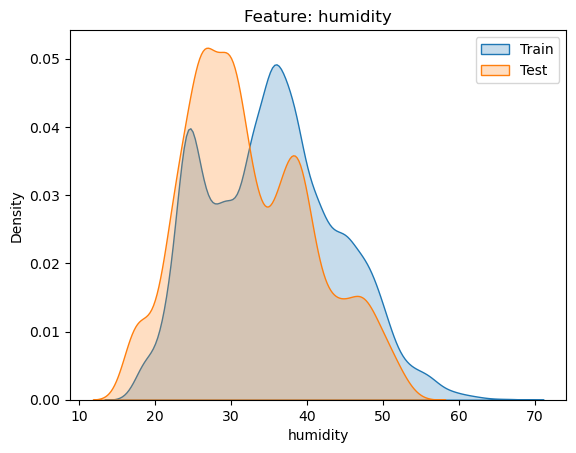

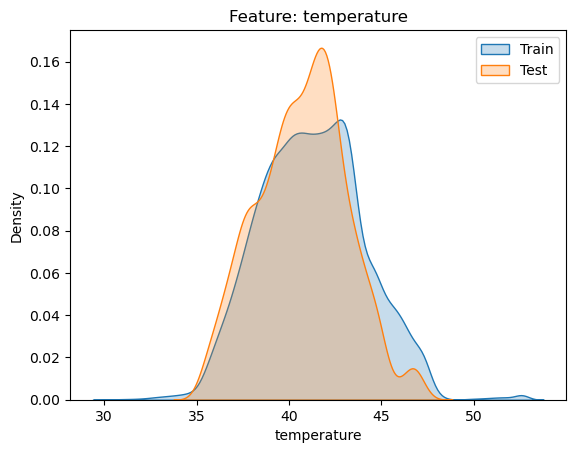

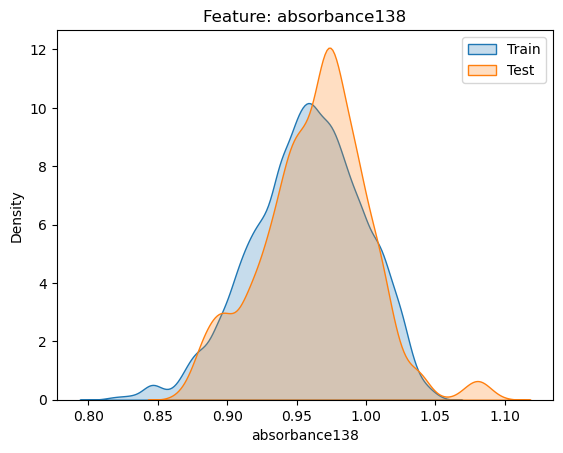

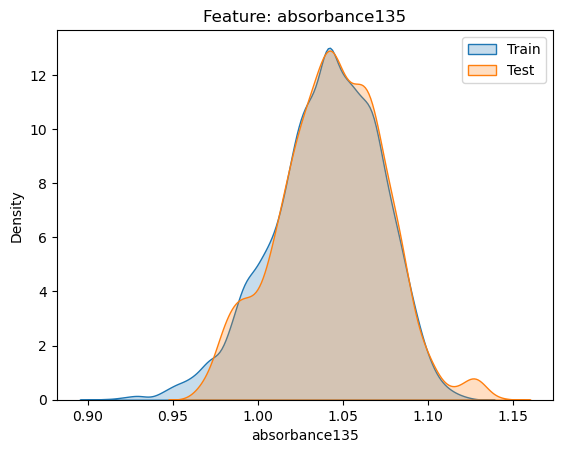

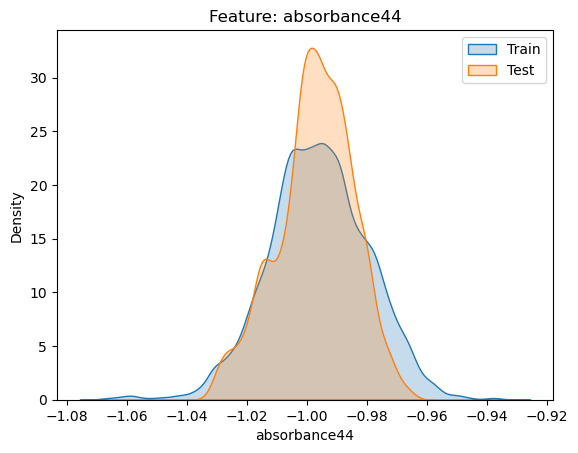

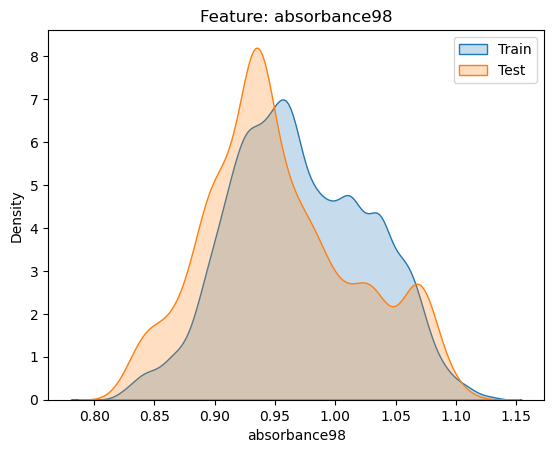

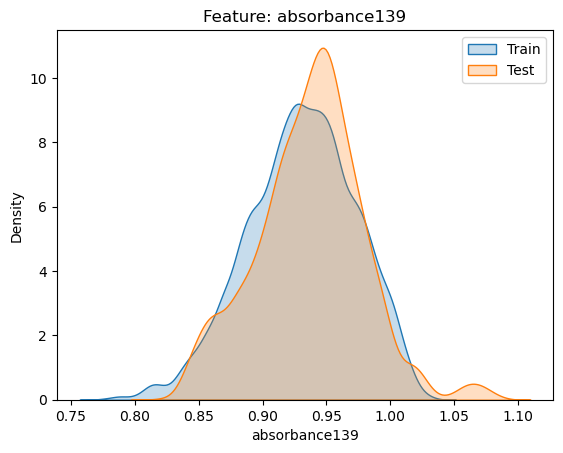

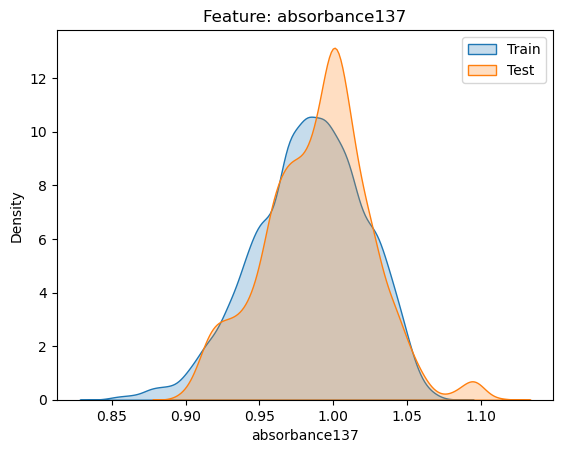

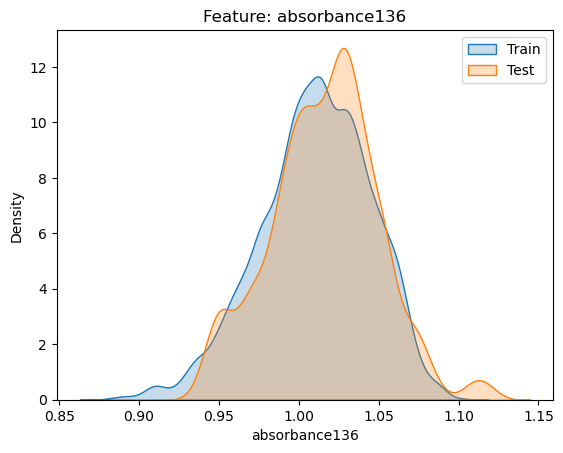

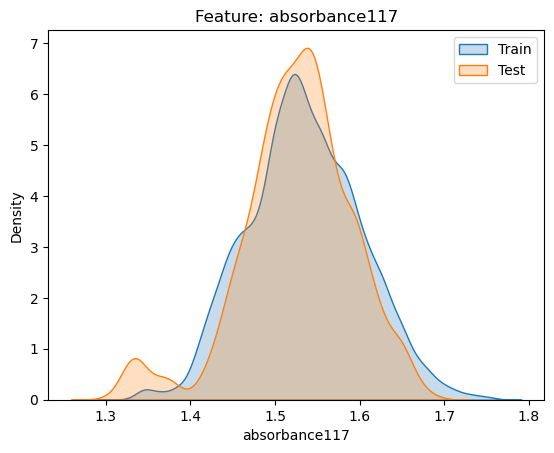

In [8]:
for column in X_train_target2.columns:
    sns.kdeplot(X_train_target1[column], label='Train', shade=True)
    sns.kdeplot(X_test[column], label='Test', shade=True)
    plt.title(f"Feature: {column}")
    plt.legend()
    plt.show()


In [9]:
from scipy.stats import ks_2samp
for col in X_train_target2.columns.tolist():
    stat, p_value = ks_2samp(X_train_target1[col], X_test[col])
    print(f"KS Statistic for {col}: {stat}, P-value: {p_value}")


KS Statistic for humidity: 0.20215931496817074, P-value: 5.953539260792967e-117
KS Statistic for temperature: 0.1132933355867275, P-value: 8.3593660034426e-37
KS Statistic for absorbance138: 0.08471297391696242, P-value: 9.574593484783472e-21
KS Statistic for absorbance135: 0.03148329671567798, P-value: 0.0031085580131470286
KS Statistic for absorbance44: 0.09723057855895445, P-value: 3.3329310852498825e-27
KS Statistic for absorbance98: 0.17334009351585822, P-value: 6.837146277180495e-86
KS Statistic for absorbance139: 0.07943158131936229, P-value: 2.740547140051785e-18
KS Statistic for absorbance137: 0.08468142639851273, P-value: 9.914415330729797e-21
KS Statistic for absorbance136: 0.07369387640132946, P-value: 8.448581856731699e-16
KS Statistic for absorbance117: 0.06952678722325512, P-value: 4.140105538691539e-14



Visualizing dataset shift for target: hdl_cholesterol_human


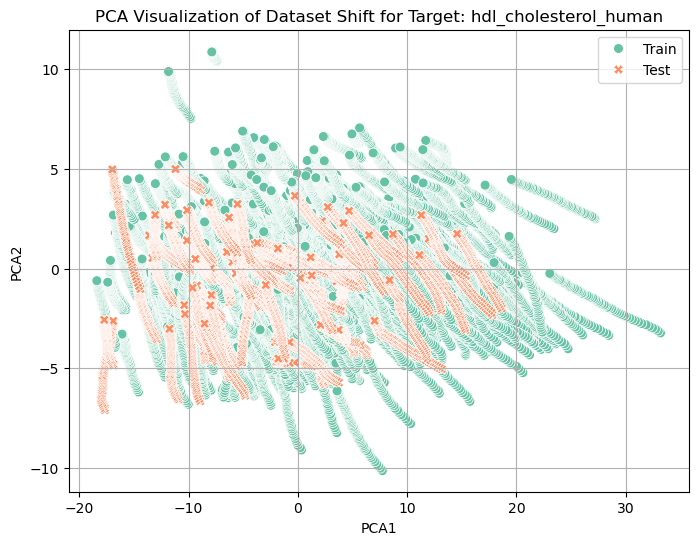


Visualizing dataset shift for target: hemoglobin(hgb)_human


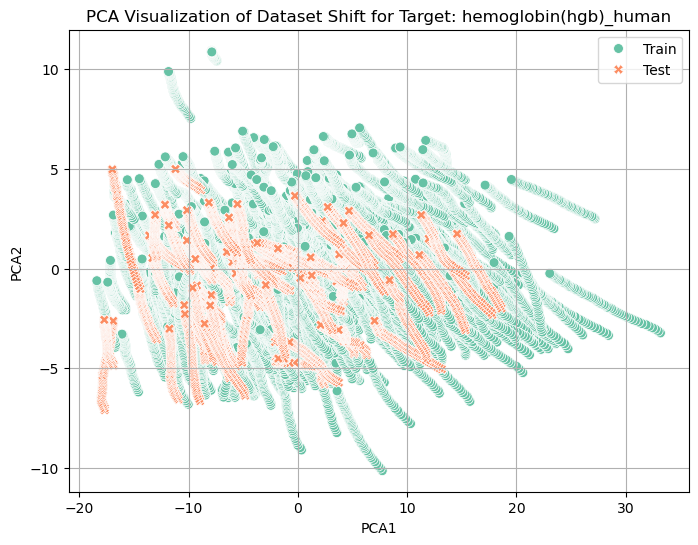


Visualizing dataset shift for target: cholesterol_ldl_human


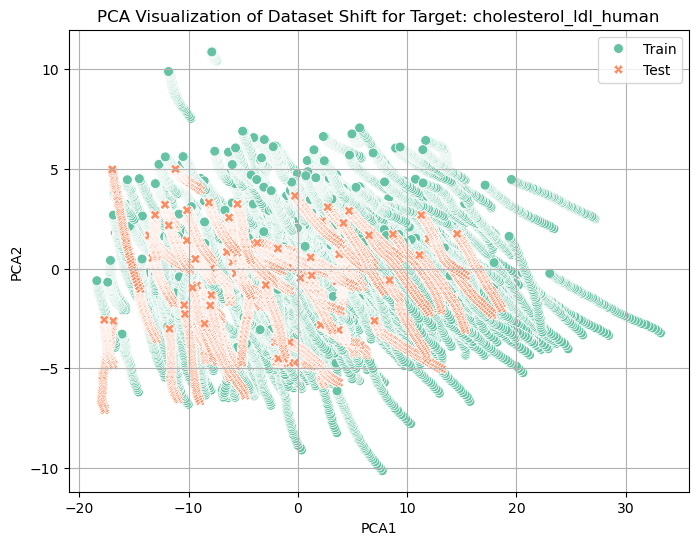

In [337]:
from sklearn.decomposition import PCA

# Function to visualize dataset shifts
def visualize_dataset_shift(X_train, X_test, target_name):
    """
    Visualizes the dataset shift between train and test sets for a given target using PCA.

    Parameters:
    - X_train: Train feature matrix (Pandas DataFrame).
    - X_test: Test feature matrix (Pandas DataFrame).
    - target_name: Name of the target being visualized (string).
    """
    print(f"\nVisualizing dataset shift for target: {target_name}")

    X_train['Dataset'] = 'Train'
    X_test['Dataset'] = 'Test'

    combined_data = pd.concat([X_train, X_test], axis=0)

    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(combined_data.drop('Dataset', axis=1))

    pca_df = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2'])
    pca_df['Dataset'] = combined_data['Dataset'].values

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Dataset', style='Dataset', palette='Set2', s=50)
    plt.title(f"PCA Visualization of Dataset Shift for Target: {target_name}")
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.grid()
    plt.show()


visualize_dataset_shift(X_train_target1, X_test_target1, "hdl_cholesterol_human")
visualize_dataset_shift(X_train_target2, X_test_target2, "hemoglobin(hgb)_human")
visualize_dataset_shift(X_train_target3, X_test_target3, "cholesterol_ldl_human")


In [ ]:
y_train = train[target_columns + ['donation_id']]

In [7]:
def group_train_data_by_donation_id(train_data, train_labels, donation_id_column, extra_columns):
    """
    Groups train data by `donation_id` and calculates mean for numeric features.

    Parameters:
    - train_data: DataFrame containing features and `donation_id`.
    - train_labels: DataFrame or Series containing target labels.
    - donation_id_column: The column name representing unique donor IDs.
    - target_columns: List of target column names to retain.

    Returns:
    - grouped_train_data: DataFrame with aggregated donor-level features and labels.
    """

    absorbance_columns = [col for col in train_data.columns if 'absorbance' in col and '_std' not in col]
    train_data = train_data[[donation_id_column] + absorbance_columns + extra_columns]

    donor_means = train_data.groupby(donation_id_column)[absorbance_columns + extra_columns].mean()

    labels_aligned = train_labels.groupby(train_data[donation_id_column]).first()  # Use the first label for each donor
    grouped_train_data = donor_means.merge(labels_aligned[target_columns], left_index=True, right_index=True)

    return grouped_train_data

donation_id_column = 'donation_id'   
extra_columns = ['humidity', 'temperature']
# Group train data
grouped_train_data = group_train_data_by_donation_id(X_train, y_train, donation_id_column, extra_columns)

print(f"Grouped train data shape: {grouped_train_data.shape}")


Grouped train data shape: (485, 175)


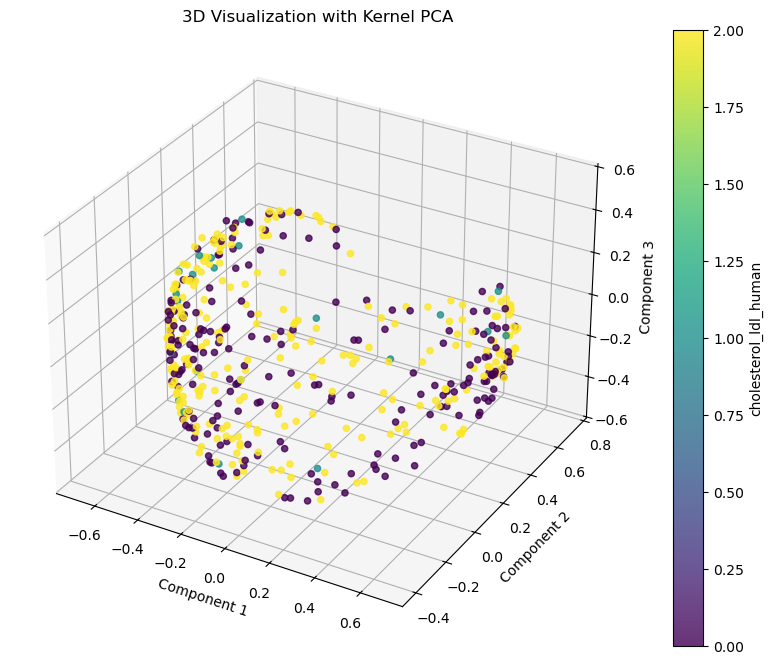

In [8]:
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D

def visualize_3d_nonlinear(data, target_column, n_components=3, kernel='rbf'):
    """
    Perform non-linear dimensionality reduction using Kernel PCA and visualize data in 3D.

    Parameters:
    - data: DataFrame containing the donor-level data (features and target).
    - target_column: Column name of the target variable for color coding.
    - n_components: Number of components for dimensionality reduction (default 3).
    - kernel: Kernel type for Kernel PCA (default 'rbf').

    Returns:
    - None (displays a 3D scatter plot).
    """
   
    features = data.drop(columns=[target_column]).values
    target = data[target_column].values
    
    # Apply Kernel PCA
    kpca = KernelPCA(n_components=n_components, kernel=kernel, random_state=42)
    transformed_features = kpca.fit_transform(features)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        transformed_features[:, 0],
        transformed_features[:, 1],
        transformed_features[:, 2],
        c=target,
        cmap='viridis',
        alpha=0.8
    )
    
    plt.colorbar(scatter, label=target_column)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    ax.set_title("3D Visualization with Kernel PCA")
    plt.show()

visualize_3d_nonlinear(grouped_train_data, target_column='cholesterol_ldl_human')


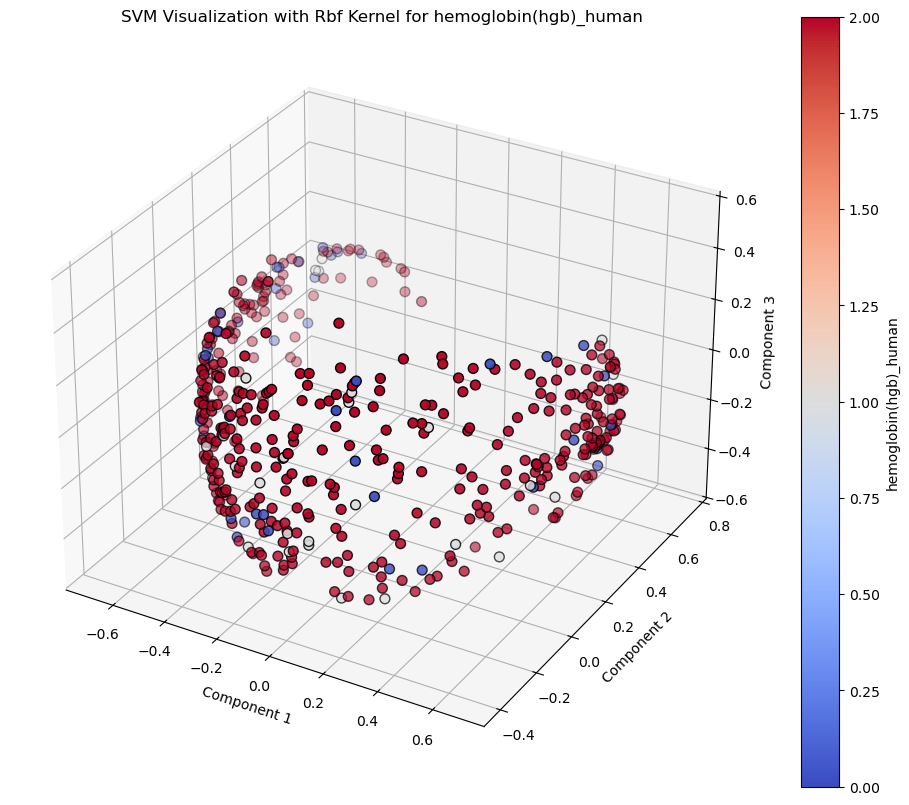

In [9]:
from sklearn.svm import SVC

def visualize_svm_with_kernel_3d(grouped_data, target_column, kernel):
    """
    Train and visualize SVM with kernel for grouped data in 3D.

    Parameters:
    - grouped_data: Grouped train data.
    - target_column: Name of the target variable.
    - kernel: Kernel type for SVM (e.g., 'rbf', 'poly').
    """
    features = grouped_data.drop(columns=target_columns)
    target = grouped_data[target_column]

    kpca = KernelPCA(n_components=3, kernel=kernel, random_state=42)
    reduced_features = kpca.fit_transform(features)

    svm_model = SVC(kernel=kernel, gamma='auto', C=1.0)
    svm_model.fit(reduced_features, target)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        reduced_features[:, 2],
        c=target,
        cmap=plt.cm.coolwarm,
        edgecolor='k',
        s=50
    )

    ax.set_title(f"SVM Visualization with {kernel.capitalize()} Kernel for {target_column}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    fig.colorbar(scatter, ax=ax, label=target_column)

    plt.show()

target_column = 'hemoglobin(hgb)_human'  
visualize_svm_with_kernel_3d(grouped_train_data, target_column, kernel='rbf')


In [10]:
def group_test_data_by_donation_id(test_data, donation_id_column, extra_columns):
    """
    Groups test data by `donation_id` and calculates mean for numeric features, retaining specified extra columns.

    Parameters:
    - test_data: DataFrame containing features and `donation_id`.
    - donation_id_column: The column name representing unique donor IDs.
    - extra_columns: List of extra columns (e.g., humidity, temperature) to retain.

    Returns:
    - grouped_test_data: DataFrame with aggregated donor-level features.
    """
    if donation_id_column not in test_data.columns:
        raise KeyError(f"Column '{donation_id_column}' not found in the dataset.")

    absorbance_columns = [col for col in test_data.columns if 'absorbance' in col]
    test_data = test_data[[donation_id_column] + absorbance_columns + extra_columns]

    donor_means = test_data.groupby(donation_id_column)[absorbance_columns + extra_columns].mean()

    return donor_means


donation_id_column = 'donation_id' 
extra_columns = ['humidity', 'temperature']  
grouped_test_data = group_test_data_by_donation_id(X_test, donation_id_column, extra_columns)

print(f"Grouped test data shape: {grouped_test_data.shape}")


Grouped test data shape: (61, 172)


In [11]:
# Group the targets based on 'donation_id'
def group_targets_by_donation_id(data, target_column, donation_id_column):
    """
    Groups target values by donation_id.

    Parameters:
    - data: DataFrame containing the target values and the donation_id column.
    - target_column: Column name of the target to group.
    - donation_id_column: Column name for grouping.

    Returns:
    - grouped_targets: Series of grouped targets, indexed by donation_id.
    """
    if donation_id_column not in data.columns:
        raise KeyError(f"Column '{donation_id_column}' not found in the dataset.")

    grouped_targets = data.groupby(donation_id_column)[target_column].mean()
    return grouped_targets

# Example usage for each target
grouped_targets = {}
for target_column in ["hdl_cholesterol_human", "hemoglobin(hgb)_human", "cholesterol_ldl_human"]:
    grouped_targets[target_column] = group_targets_by_donation_id(
        y_train,
        target_column=target_column,
        donation_id_column="donation_id"
    )


In [12]:
# Apply selected features to the grouped data
X_train_target1 = grouped_train_data[selected_features["Target1"]]
X_train_target2 = grouped_train_data[selected_features["Target2"]]
X_train_target3 = grouped_train_data[selected_features["Target3"]]

X_test_target1 = X_test[selected_features["Target1"]]
X_test_target2 = X_test[selected_features["Target2"]]
X_test_target3 = X_test[selected_features["Target3"]]

In [13]:
from sklearn.model_selection import StratifiedKFold

# Map targets to their respective datasets
target_to_dataset = {
    "hdl_cholesterol_human": X_train_target1,
    "hemoglobin(hgb)_human": X_train_target2,
    "cholesterol_ldl_human": X_train_target3,
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

splits = {}

for target, X_target in target_to_dataset.items():
    
    y_target = grouped_targets[target]
    
    splits[target] = list(skf.split(X_target, y_target))

In [18]:
baseline_model = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                       min_samples_split=15, n_estimators=160,
                                       random_state=42)

results = {}

for target, fold_splits in splits.items():
    print(f"\n=== Training Models for Target: {target} ===")

    X_target = target_to_dataset[target]
    y_target = y_train[target]

    results[target] = []

    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(fold_splits):
        # Split the data
        X_train_fold = X_target.iloc[train_idx]
        X_val_fold = X_target.iloc[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        model = baseline_model
        model.fit(X_train_fold, y_train_fold)

        y_val_pred = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        print(f"  Fold {fold + 1}: Accuracy = {accuracy:.4f}")

        results[target].append(accuracy)

# Summary of results
for target, accuracies in results.items():
    print(f"\n{target} Average Accuracy: {sum(accuracies) / len(accuracies):.4f}")


=== Training Models for Target: hdl_cholesterol_human ===
  Fold 1: Accuracy = 0.5052
  Fold 2: Accuracy = 0.6804
  Fold 3: Accuracy = 0.5670
  Fold 4: Accuracy = 0.6392
  Fold 5: Accuracy = 0.6082

=== Training Models for Target: hemoglobin(hgb)_human ===
  Fold 1: Accuracy = 1.0000
  Fold 2: Accuracy = 1.0000
  Fold 3: Accuracy = 1.0000
  Fold 4: Accuracy = 1.0000
  Fold 5: Accuracy = 1.0000

=== Training Models for Target: cholesterol_ldl_human ===
  Fold 1: Accuracy = 0.5052
  Fold 2: Accuracy = 0.4742
  Fold 3: Accuracy = 0.5258
  Fold 4: Accuracy = 0.5670
  Fold 5: Accuracy = 0.5361

hdl_cholesterol_human Average Accuracy: 0.6000

hemoglobin(hgb)_human Average Accuracy: 1.0000

cholesterol_ldl_human Average Accuracy: 0.5216
